#  Online Game User Churn Rate Prediction

---------------------------------------
### 이탈률 정의





 -----------------------------------
 


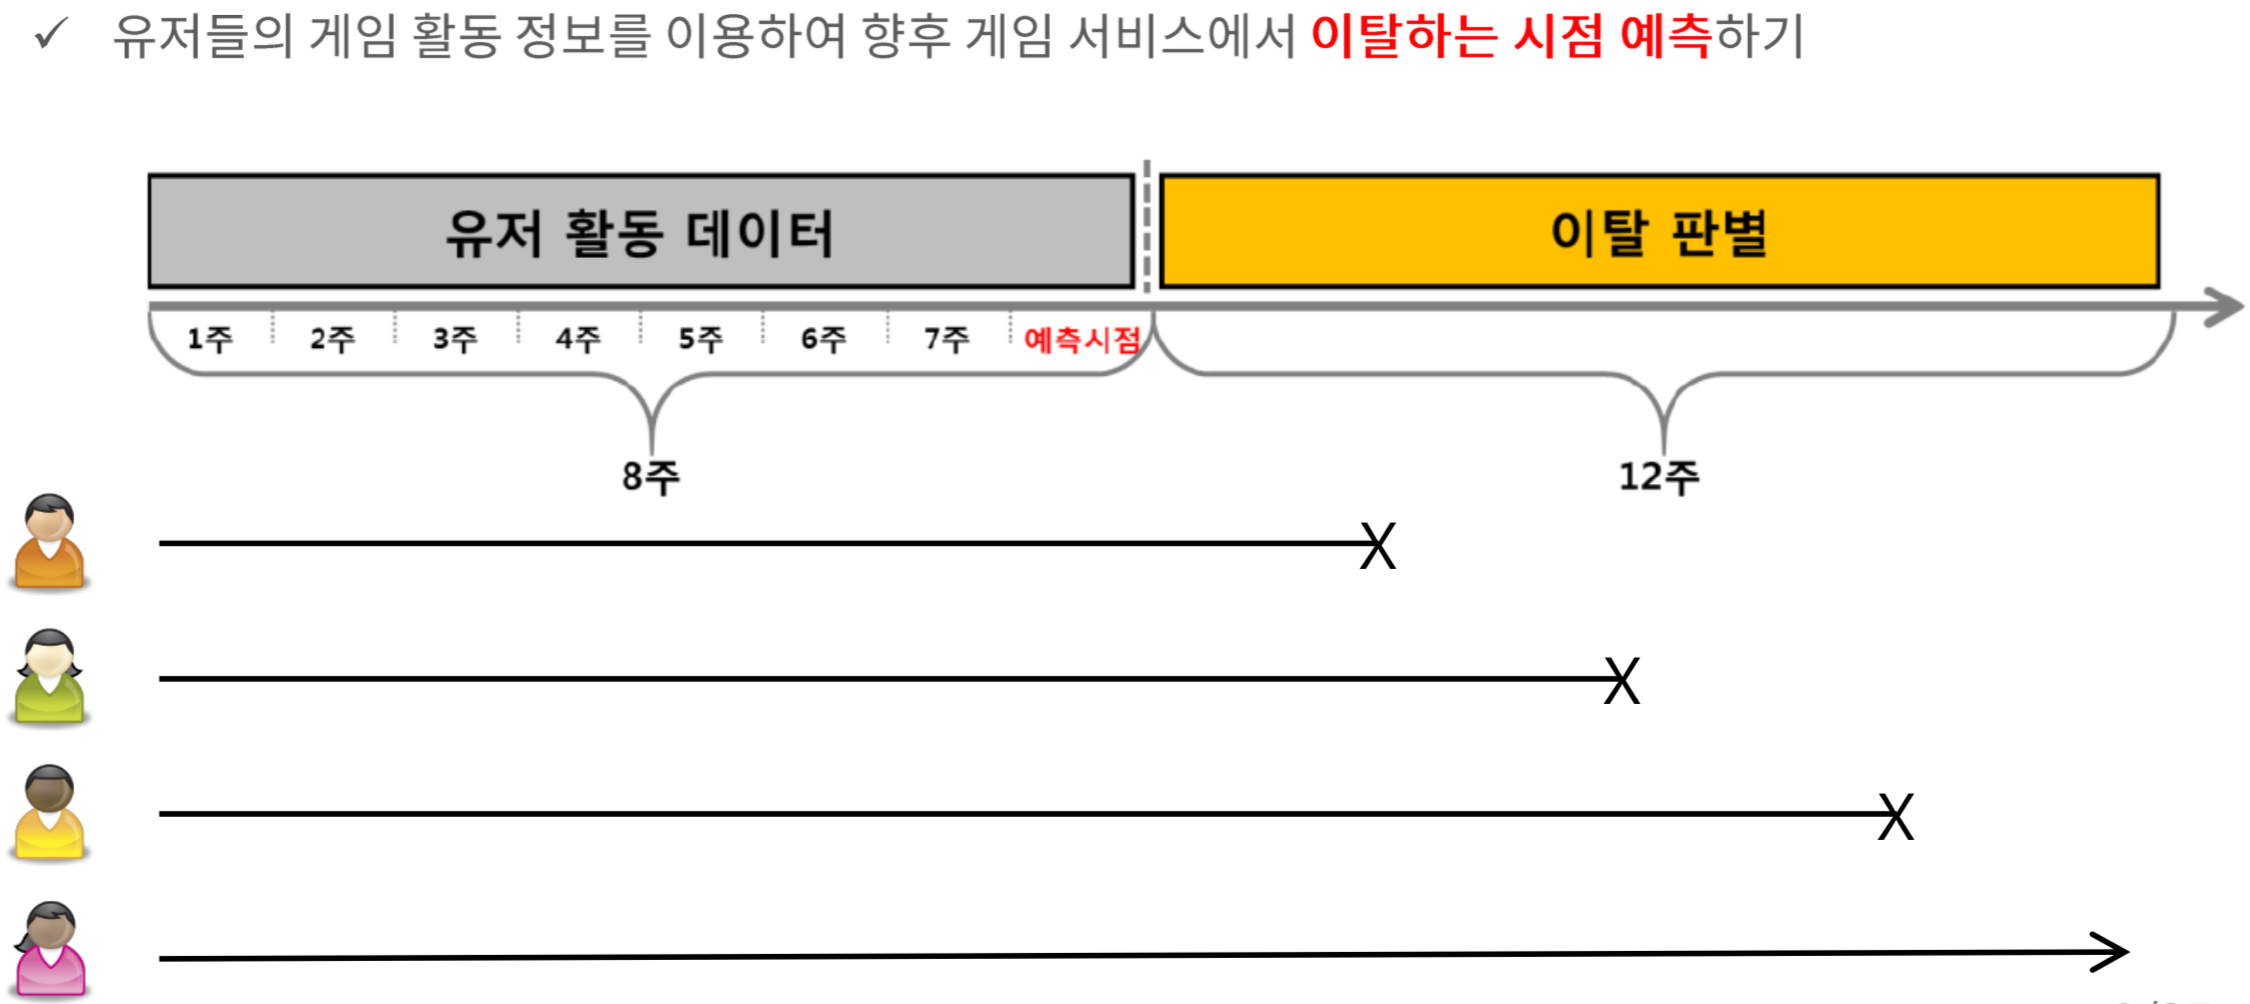

In [16]:
from IPython.display import Image, display
Image('sc_01.png')

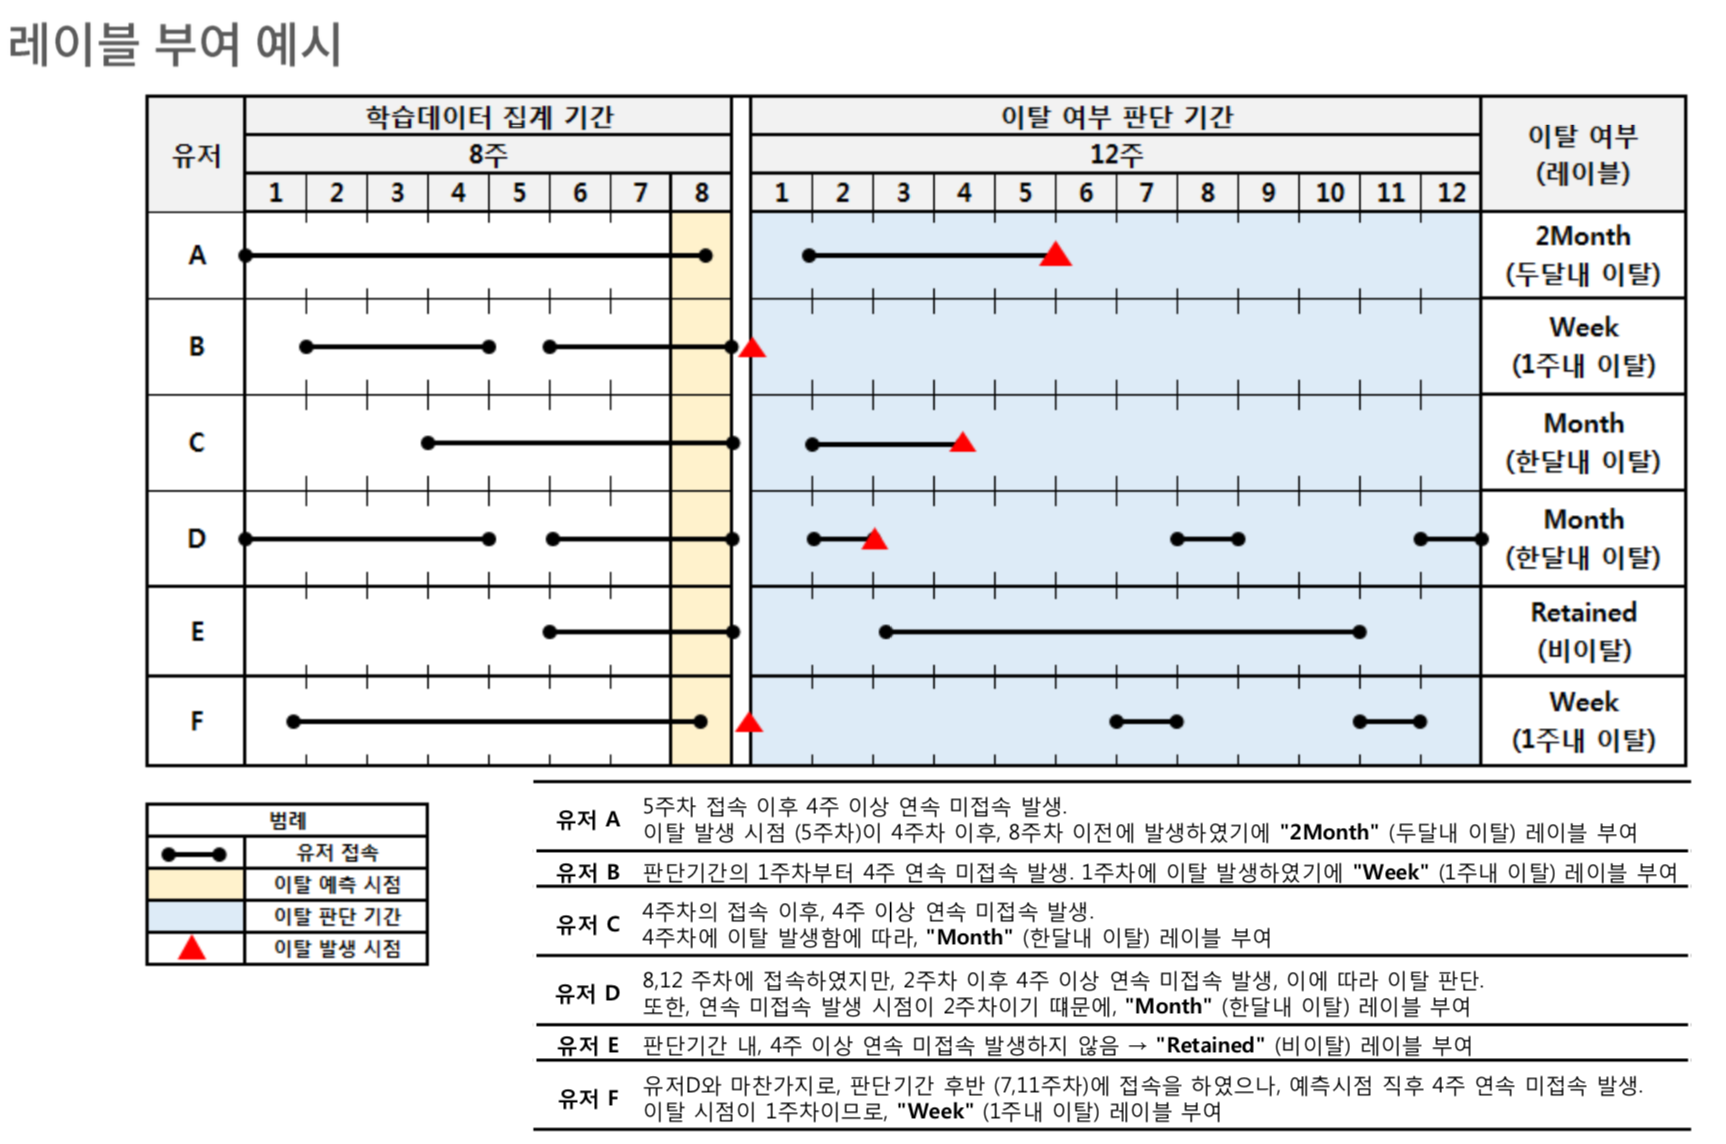

In [17]:
Image('sc_02.png')

## Data 탐색
### Import , Read data

In [1]:
#package load
import pandas as pd
import numpy as np
import os
dicpath = os.getcwd()

#데이터 셋의 행, 열의 길이 출력
def shape_search(tr,ts):
    print('train data shape: ', tr.shape,'test data shape: ', ts.shape)

#결측치 찾기
def missing_values_table(df):
    # 총 결측치 개수
    mis_val = df.isnull().sum()

    # 결측치 비율
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # df으로 만들기
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # 컬럼명 바꾸기
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # 내림차순으로 결측치 비율 소팅
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    return mis_val_table_ren_columns    

In [2]:
#데이터 불러오기
train_activity = pd.read_csv(dicpath+'/train/train_activity.csv',encoding='EUC-kr')
train_guild = pd.read_csv(dicpath+'/train/train_guild.csv',encoding='EUC-kr')
train_party = pd.read_csv(dicpath+'/train/train_party.csv',encoding='EUC-kr')
train_payment = pd.read_csv(dicpath+'/train/train_payment.csv',encoding='EUC-kr')
train_trade = pd.read_csv(dicpath+'/train/train_trade.csv',encoding='EUC-kr')
train_label = pd.read_csv(dicpath+'/train/train_label.csv',encoding='EUC-kr')

test_activity = pd.read_csv(dicpath+'/test/test_activity.csv',encoding='EUC-kr')
test_guild = pd.read_csv(dicpath+'/test/test_guild.csv',encoding='EUC-kr')
test_party = pd.read_csv(dicpath+'/test/test_party.csv',encoding='EUC-kr')
test_payment = pd.read_csv(dicpath+'/test/test_payment.csv',encoding='EUC-kr')
test_trade = pd.read_csv(dicpath+'/test/test_trade.csv',encoding='EUC-kr')
test_label = pd.DataFrame(test_payment["acc_id"].unique())
test_label.columns = ["acc_id"]

### Data Shape

In [3]:
#각 데이터 테이블의 행과 길이
#학습 셋은 10만명의 유저이고 테스트 셋은 4만명의 유저로 구성
shape_search(train_activity,test_activity)
shape_search(train_guild,test_guild)
shape_search(train_party,test_party)
shape_search(train_payment,test_payment)
shape_search(train_trade,test_trade)
shape_search(train_label,test_label)

train data shape:  (440323, 38) test data shape:  (175631, 38)
train data shape:  (9963, 2) test data shape:  (5906, 2)
train data shape:  (6962341, 7) test data shape:  (4121512, 7)
train data shape:  (800000, 3) test data shape:  (320000, 3)
train data shape:  (10414351, 7) test data shape:  (3873536, 7)
train data shape:  (100000, 2) test data shape:  (40000, 1)


In [4]:
#데이터 훑어보기
#유저의 활동 데이터, 연속형 데이터는 모두 normalize되어 있음
train_activity.head()

,wk,acc_id,cnt_dt,play_time,npc_exp,npc_hongmun,quest_exp,quest_hongmun,item_hongmun,game_combat_time,...,cnt_clear_bam,normal_chat,whisper_chat,district_chat,party_chat,guild_chat,faction_chat,cnt_use_buffitem,gathering_cnt,making_cnt
0,7,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd...,4,2.088814,4.405057,-0.245477,4.454059,3.009797,-0.306354,1.184011,...,-0.03313,-0.034038,-0.231827,-0.016574,-0.275174,-0.343293,-0.024028,3.466939,-0.027758,-0.365536
1,8,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd...,5,2.673460,4.760178,-0.222527,6.107479,4.758528,-0.306354,1.709534,...,-0.03313,-0.034038,-0.231827,-0.016574,-0.275174,-0.343293,-0.024028,5.070359,-0.027758,-0.365536
2,3,b8856358ff62e596fa07e3e40b8e7fd4b7729263c72b44...,2,-0.649522,-0.231021,-0.290803,-0.245978,-0.487666,-0.306354,-0.566706,...,-0.03313,-0.034038,-0.231827,-0.016574,-0.275174,-0.343293,-0.024028,-0.498275,-0.027758,-0.365536
3,4,b8856358ff62e596fa07e3e40b8e7fd4b7729263c72b44...,2,-0.658235,-0.231874,-0.290803,-0.250423,-0.487666,-0.306354,-0.569842,...,-0.03313,-0.034038,-0.231827,-0.016574,-0.275174,-0.343293,-0.024028,-0.503692,-0.027758,-0.365536
4,5,b8856358ff62e596fa07e3e40b8e7fd4b7729263c72b44...,4,-0.654734,-0.231874,-0.290803,-0.250423,-0.487666,-0.306354,-0.569842,...,-0.03313,-0.034038,-0.231827,-0.016574,-0.275174,-0.343293,-0.024028,-0.503692,-0.027758,-0.365536


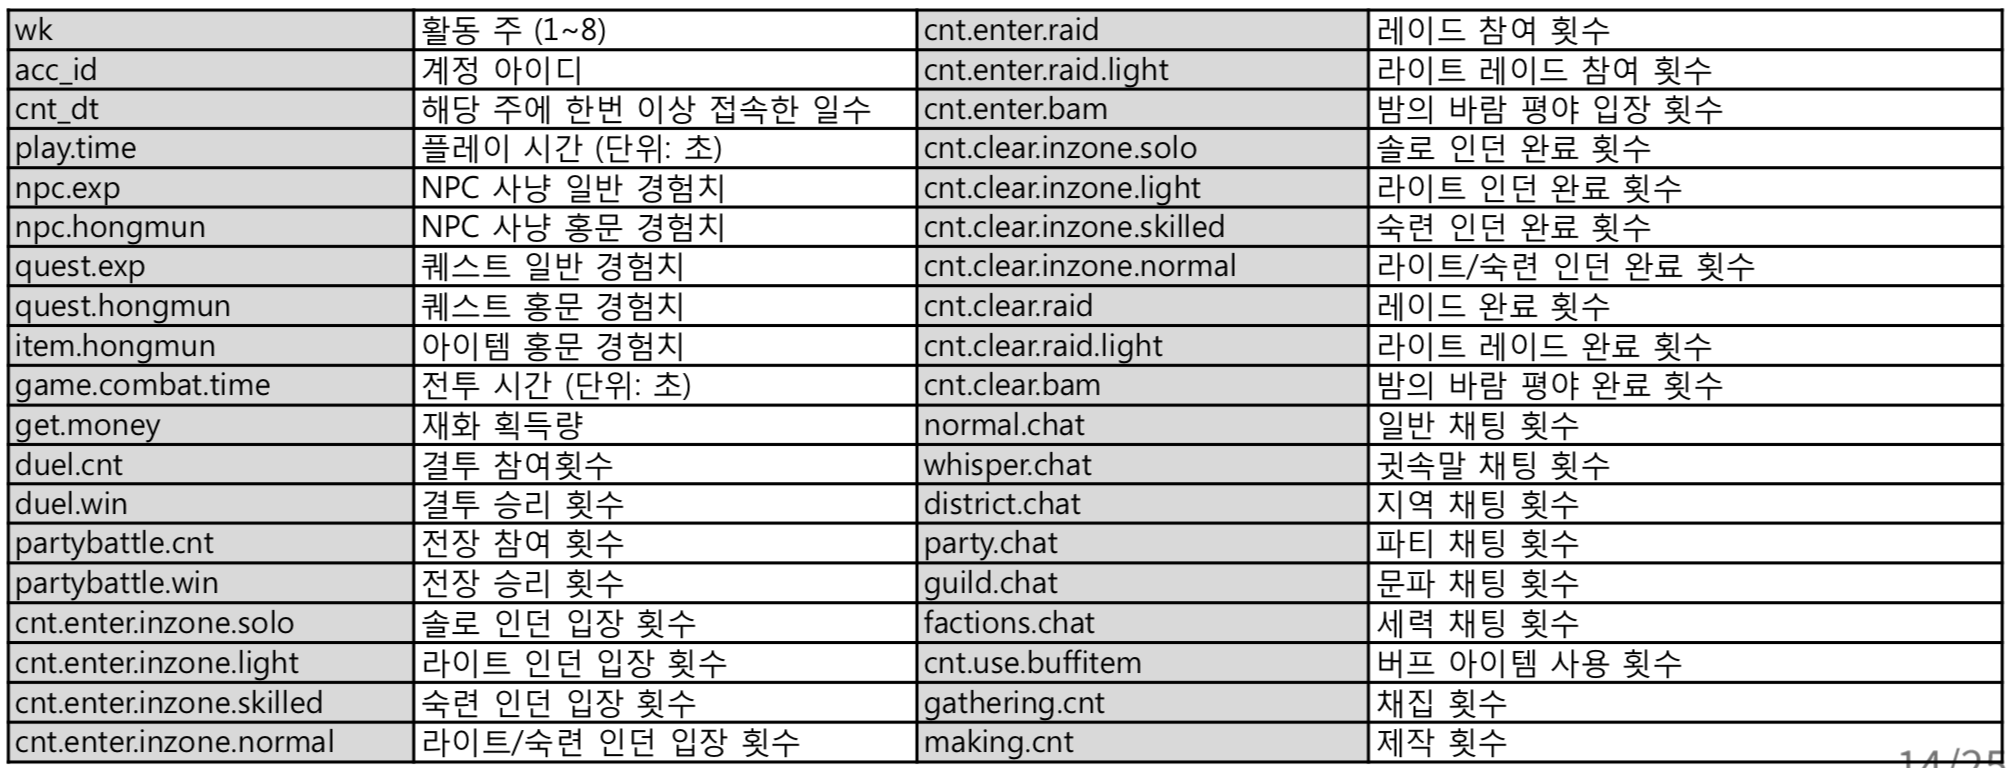

In [18]:
Image('sc3.png')

In [5]:
#길드 데이터
#하나의 길드 아이디 당 한 명의 유저 존재
train_guild.head()

,guild_id,guild_member_acc_id
0,000b682e9e50904b317c6f4afe17d8ee38b8c339f08bf9...,ba86804424a9a3708b1564a7726783612a75a5b881095e...
1,000f26195f92ca13ec8683a6961a6c31ad07efde0d7b80...,ddea37c9b636c4b1650414052f6ede370481e9e236b193...
2,0015cb37aef2cef211f106244519ea8031c04091c9ac34...,9eee6b10b87dce56b7b1eae9d591e16ec128d0c8376c28...
3,001cbf66fa9c3e0ccead23d1c9cc444cb5a2ea3d5ab874...,25810af9e9cff193561a77da73684a3113c3c1539168b1...
4,001ce79ebfcf328508c8d61c476e5bacb3d84f029b5623...,fa5e9cb3dadb37c4797ca7785ea99558ebef24bcbbf844...


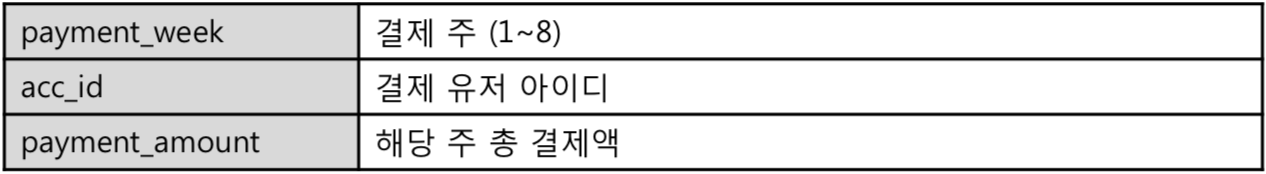

In [19]:
Image('sc4.png')

In [6]:
#파티 데이터
#파티 생성과 해체 시간 데이터와 파티 구성원 숫자. 구성원 숫자는 행 별로 다를 수 있음
train_party.head()

,party_start_week,party_start_day,party_start_time,party_end_week,party_end_day,party_end_time,hashed
0,1,1,09:14:58.558,1,1,09:41:30.200,11fc85879e5ac9d5c83bfba10d73c4c84c154b9f4d9e1d...
1,3,3,11:05:05.176,3,3,13:07:42.515,7176c1516207692857535c30a4650b8e8e586af1fed0fd...
2,3,6,02:18:43.172,3,6,02:28:58.177,8092e194a750aae539862ed4405f67a6dd5b492e7e57e3...
3,4,1,09:22:01.936,4,1,09:47:40.192,4ec597c569b92bd0e1bae4e2a06e13b9657fb81795e194...
4,4,5,06:29:21.182,4,5,06:50:55.004,a4b6aea6cb58e43911e7cb7d6c0497197db7c4ed16e1c9...


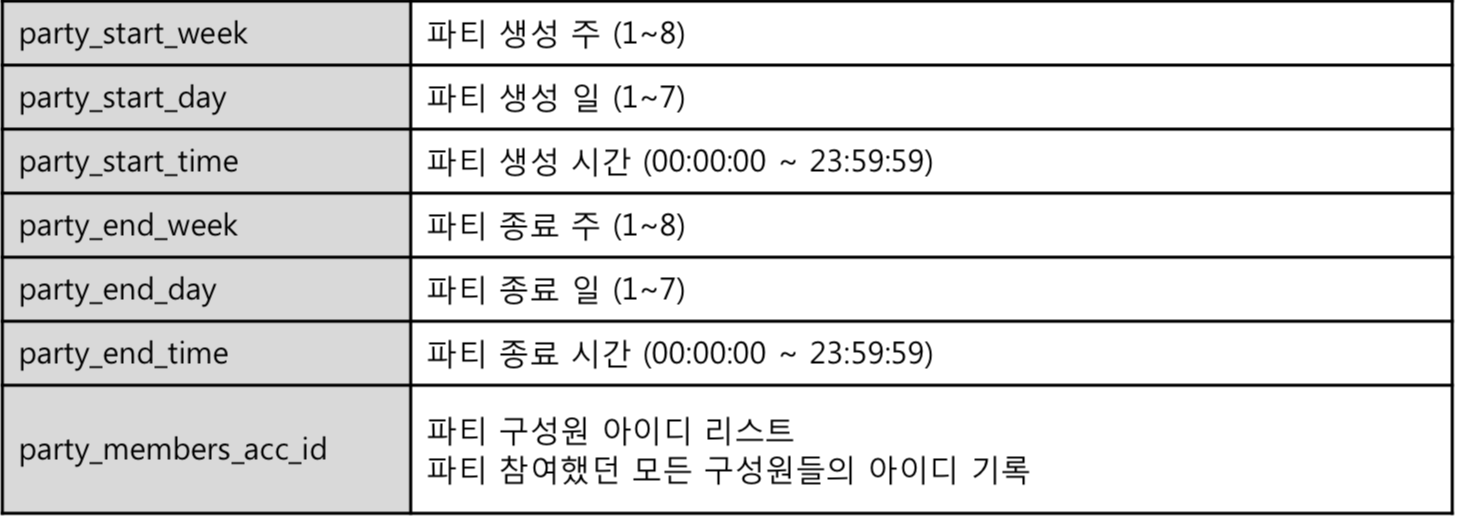

In [20]:
Image('sc5.png')

In [7]:
#결제 데이터
#주별 결제금액. 8주 * 10만명 = 80만개의 데이터 존재 결제 금액이 -0.149898인경우 결제 안함 으로 추정
train_payment.head()

,payment_week,acc_id,payment_amount
0,1,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd...,-0.149898
1,2,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd...,-0.149898
2,3,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd...,-0.149898
3,4,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd...,-0.149898
4,5,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd...,-0.149898


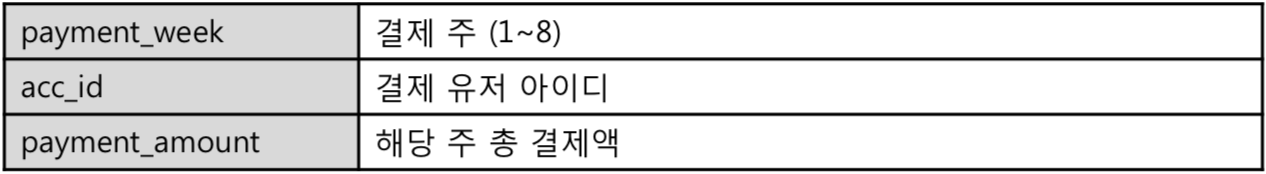

In [21]:
Image('sc4.png')

In [8]:
#유저간 거래 데이터
#거래 시간과 종류 양, 판매자, 구매자로 구성
train_trade.head()

,trade_week,trade_day,trade_time,source_acc_id,target_acc_id,item_type,item_amount
0,8,2,23:32:06,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd...,96995041e6295f5a5aa86d07f805ec3b38aef10dc08f99...,grocery,-0.056344
1,7,6,05:06:31,3dc6f2875dc6e6f35b9e2bdb25b391a8003386ff23becd...,7d9700471abcd1bc304d7f9b72bb906e7602a0a7565525...,grocery,-0.056343
2,1,2,20:05:18,6ac252acf5ce113d2eb251d62ee2713c269655be3f8bec...,bedcc9bb1a9ba468f9e63321d2ee6fe25a1043f941177d...,grocery,-0.056346
3,1,2,22:18:09,6ac252acf5ce113d2eb251d62ee2713c269655be3f8bec...,bedcc9bb1a9ba468f9e63321d2ee6fe25a1043f941177d...,grocery,-0.056346
4,1,3,00:31:10,6ac252acf5ce113d2eb251d62ee2713c269655be3f8bec...,bedcc9bb1a9ba468f9e63321d2ee6fe25a1043f941177d...,grocery,-0.056346


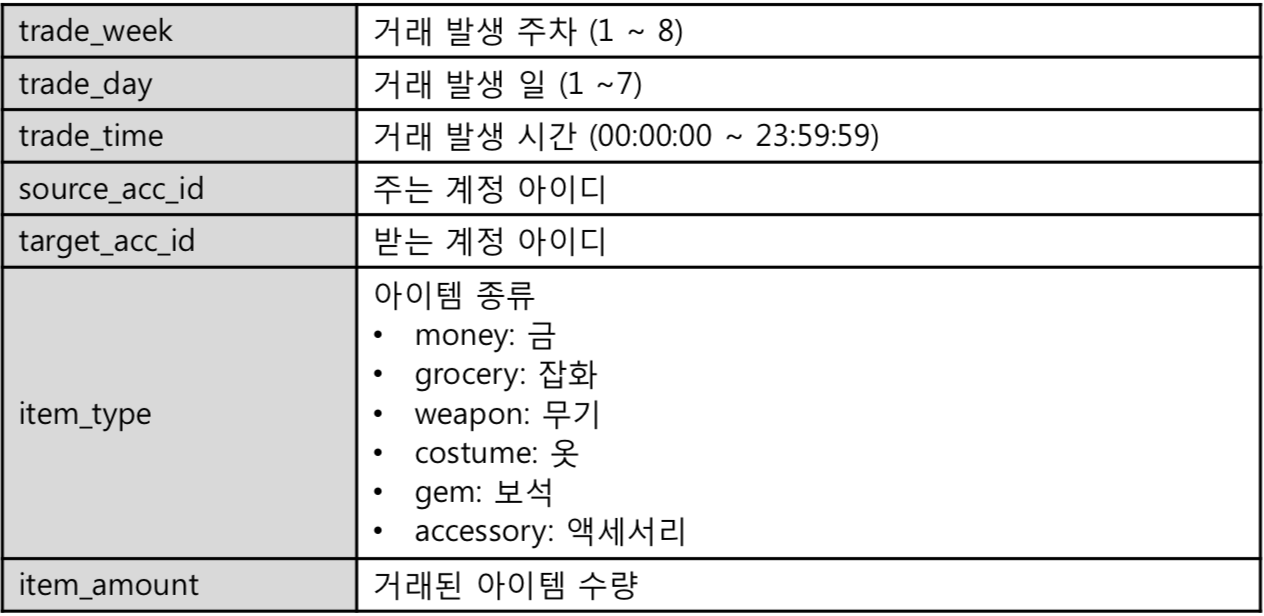

In [22]:
Image('sc7.png')

In [9]:
#학습셋 유저들의 y값
#retained : 유지
#2month : 2달내 이탈
#month : 한달내 이탈
#week : 일주내 이탈
#class가 4개인 multiclass classification 문제 
train_label.head()

,acc_id,label
0,b8fbf3f6a70e3f36843bffc70c18ff51a0d755a87616ec...,week
1,ed500c4957956b3e99dc3985666850b582f812405eefb6...,week
2,acc6afa23a6bf15e18151e4794c7789225ef9d682f473c...,week
3,34095a3c9a2937ced3ea3fd75e22ce177dc5879d2a53f7...,week
4,26f3db6e8817a93c4ceda9a16f0832945e43d950b95882...,week


In [10]:
#학습셋 유저들의 비율
#balanced data set
train_label["label"].value_counts()

retained    25000
week        25000
month       25000
2month      25000
Name: label, dtype: int64

### Missing Values

In [11]:
#결측 데이터 처리
#기본적으로 결측값은 없지만 데이터 aggregation 과정에서 발생 -> 각각의 케이스에 맞춰 횟수의 경우 0, 정규화된 경우 최솟값에 하는 등 상황에 맞는 처리
missing_values_table(train_activity)
missing_values_table(train_guild)
missing_values_table(train_party)
missing_values_table(train_trade)
missing_values_table(train_payment)

Your selected dataframe has 38 columns.
There are 0 columns that have missing values.
Your selected dataframe has 2 columns.
There are 0 columns that have missing values.
Your selected dataframe has 7 columns.
There are 0 columns that have missing values.
Your selected dataframe has 7 columns.
There are 0 columns that have missing values.
Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Column Type

In [12]:
#컬럼의 데이터 타입 확인
print('train_activity :',train_activity.dtypes.value_counts())
    #int는 각각 wk와 cnd_dt / object는 acc_id
print('train_guild :',train_guild.dtypes.value_counts())
    #길드명과 가입된 아이디
print('train_party :',train_party.dtypes.value_counts())
    #int는 파티 생성, 종료 주차 및 날짜 / object는 생성, 종료 시간 및 acc_id
print('train_trade :',train_trade.dtypes.value_counts())
    #int는 거래 주차 및 날짜 / object는 거래 시간, 판매자 id, 구매자 id, 거래 품목
print('train_payment :',train_payment.dtypes.value_counts())
    #int는 결제 주차 / object는 acc_id

train_activity : float64    35
int64       2
object      1
dtype: int64
train_guild : object    2
dtype: int64
train_party : int64     4
object    3
dtype: int64
train_trade : object     4
int64      2
float64    1
dtype: int64
train_payment : float64    1
int64      1
object     1
dtype: int64


### EDA

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def EDA_num_col(X,y,col,color='green'):
    
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(14,6))
    plt.suptitle("Density plot of {}".format(col),fontsize = 16)
    sns.set_color_codes("pastel")
    sns.set_style('white')
    
    #plot 1
    s = sns.distplot(ax = ax1, a = X[col].dropna(), color = color, kde=True, bins = 100, axlabel = col, label = "Density of {}".format(col))
    ax1.set(xlabel = col, ylabel = "density")
    
    #plot 2
    X0 = X.loc[y == "retained"][col]
    X1 = X.loc[y == "week"][col]
    X2 = X.loc[y == "month"][col]
    X3 = X.loc[y == "2month"][col]
    
    s = sns.kdeplot(X0, bw = 0.5, label = "Target = retained", ax = ax2)
    s = sns.kdeplot(X1, bw = 0.5, label = "Target = week", ax = ax2)
    s = sns.kdeplot(X2, bw = 0.5, label = "Target = month", ax = ax2)
    s = sns.kdeplot(X3, bw = 0.5, label = "Target = 2month", ax = ax2)
    
    ax2.set(label = col, ylabel = "density")
    
    plt.tick_params(axis = "both", which = "major", labelsize = 12)
    plt.show()



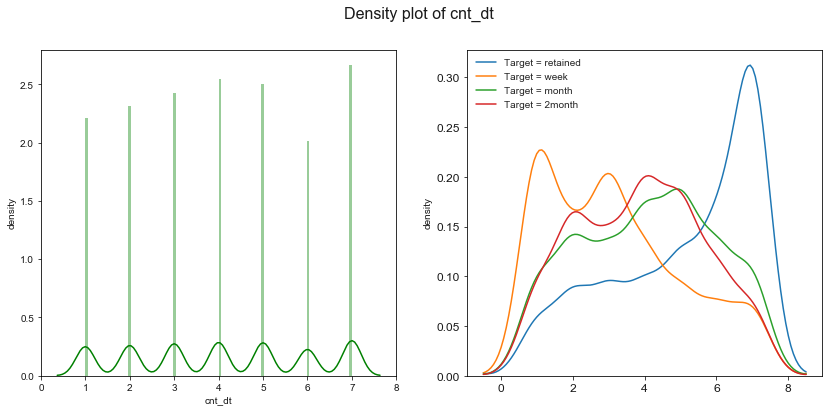

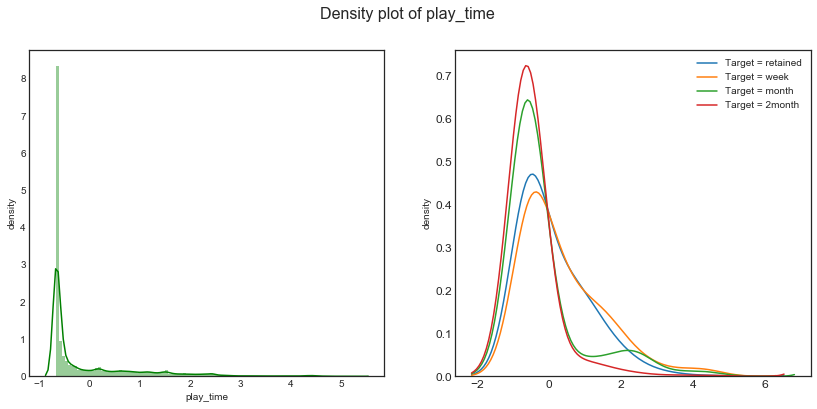

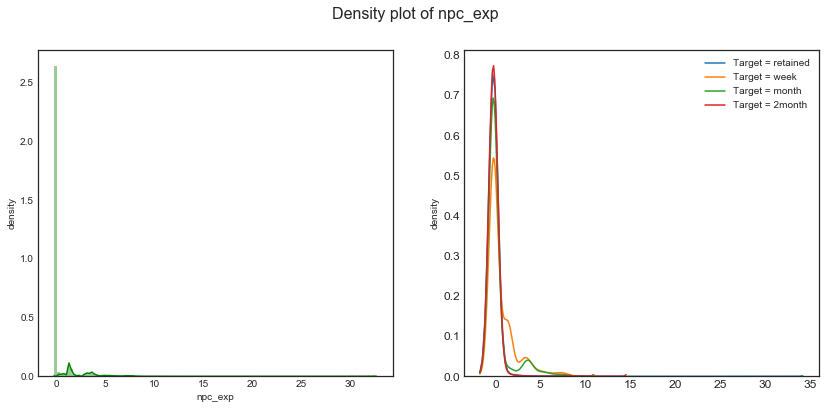

In [14]:
wk8 = train_activity[train_activity.wk == 8]
train_activity_wk8 = train_label.merge(wk8,how='left',on='acc_id').drop(['wk'],axis=1)
for col in train_activity_wk8.columns[2:5]:
    EDA_num_col(train_activity_wk8,train_activity_wk8["label"],col)